# Assignment 1-B

We have to fit various regression models to a dataset containing 546 samples, where the $n$-th sample is of the form:

$$ (x_{n_1}, x_{n_2}, y_{n}) $$

where $(x_{n_1}, x_{n_2})$ are the features and $y_{n}$ is the target value. 

In [15]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from math import sqrt
from mpl_toolkits import mplot3d
from matplotlib import cm

In [16]:
# data = pd.read_csv("fods_1.csv").to_numpy()
data = pd.read_csv("fods_1.csv")

We create a 80-20 split of the dataset for training and testing respectively.

In [17]:
training_data = data.sample(frac = 0.8, random_state=49)
test_data = data.drop(training_data.index)

training_data = training_data.to_numpy()
test_data = test_data.to_numpy()

X_train = training_data[:, :2].T
Y_train = training_data[:,2].T

X_test = test_data[:,:2].T
Y_test = test_data[:,2].T

N_train = len(X_train[0])
N_test = len(X_test[0])

### Structure of matrices

Our feature matrix is stored as:

$$ X = \begin{pmatrix}
x_{1_1} & x_{2_1} & \ldots & x_{N_1}\\
x_{1_2} & x_{2_2} & \ldots & x_{N_2}
\end{pmatrix}_{2 \times N} $$

and the target vector is stored as:

$$ Y = \begin{pmatrix}
y_{1} & y_{2} & \ldots & y_{N}
\end{pmatrix}_{1 \times N}  $$



# POLYNOMIAL REGRESSION

### Our model

$$ f_{\textbf{w}}(\textbf{x}_{i}) = \sum_{j=0}^{M} w_jx_{i_j} $$

where $x_{i_0} = 1$ for all training examples, $x_{i_1}$ and $x_{i_2}$ correspond to the features in dataset and the remaining $x_{i_j}$'s refer to higher degree terms found by multiplying $x_{i_1}$ and $x_{i_2}$.

### Normalization

We calculate the mean ($\mu$) and standard deviation ($\sigma$) of the training data. We normalize training data as:

$$ x_{i_j} = \frac{x_{i_j} - \mu_j}{\sigma_j} $$

We also store $\mu$ and $\sigma$ vectors to normalize the testing data using the same $\mu$ and $\sigma$.

In [18]:
def normalize_train(X):

    mean = np.array(np.mean(X[1:, :], axis = 1)).reshape([len(X) - 1, 1])
    std = np.array(np.std(X[1:, :], axis = 1)).reshape([len(X) - 1, 1])

    mean = np.concatenate((np.zeros([1,1]), mean), axis = 0)
    std = np.concatenate((np.ones([1,1]), std), axis = 0)

    mean_cur = np.repeat(mean, len(X[0]), axis = 1)
    std_cur = np.repeat(std, len(X[0]), axis = 1)

    X = (X - mean_cur) / std_cur
    return (X, mean, std)

In [19]:
def normalize_test(X, mean, std):
    mean_cur = np.repeat(mean, len(X[0]), axis = 1)
    std_cur = np.repeat(std, len(X[0]), axis = 1)

    X = (X - mean_cur) / std_cur
    return X

### Generating Feature Matrix

We generate feature matrix for polynomial regression using nested for loops. We generate a matrix with all the polynomial features till degree 9, and later slice rows from this matrix to run polynomial regression for lower degrees.

Our generated feature matrix is as follows:

$$ \begin{pmatrix}
1 & 1 & \ldots & 1\\
x_{1_1} & x_{2_1} & \ldots & x_{N_1}\\
x_{1_2} & x_{2_2} & \ldots & x_{N_2}\\
(x_{1_1})^2 & (x_{2_1})^2 & \ldots & (x_{N_1})^2\\
(x_{1_1})(x_{1_2}) & (x_{1_2})(x_{2_2}) & \ldots & (x_{N_1})(x_{N_2})\\
(x_{1_2})^2 & (x_{2_2})^2 & \ldots & (x_{N_2})^2\\
\vdots & \vdots & & \vdots\\
(x_{1_2})^9 & (x_{2_2})^9 & \ldots & (x_{N_2})^9\\
\end{pmatrix} $$

In [20]:
def generate_feature_matrix(X, deg):

    mat = np.ones([1,len(X[0])])
    for i in range (1, deg + 1):
        for j in range(i+1):
            k = i - j
            newRow = np.array((X[0]**k) * (X[1]**j)).reshape([1, len(X[0])])
            mat = np.concatenate((mat, newRow), axis = 0)
            
    return mat

### Cost Function

We calculate cost function for regression as follows:
$$ \begin{align*}
&J(\textbf{w}) = \frac{1}{2} \sum_{i=1}^N (y_{i} - f_{\textbf{w}}(\textbf{x}_{i}))^2 \\ \\
&J(\textbf{w}) = \frac{1}{2}\, (\textbf{Y} - \textbf{W}^{T}\,\textbf{X})\,(\textbf{Y} - \textbf{W}^{T}\,\textbf{X})^{T}
\end{align*}$$

In [21]:
def cost_function(Y, X, W):
    return np.sum(1 / 2  * ((Y - W.T @ X) @ (Y - W.T @ X).T))

### Error Function
The error function will be the $RMS$ of the difference between the predicted value and the given value
$$ \begin{align*}
&E(\textbf{w}) = \sqrt{\frac{1}{N} \, \sum_{i=1}^N \, (y_{i} - f_{\textbf{w}}(\textbf{x}_{i}))^2} \\ \\
&E(\textbf{w}) = \sqrt{\frac{1}{N} \, (\textbf{Y} - \textbf{W}^{T}\,\textbf{X})\,(\textbf{Y} - \textbf{W}^{T}\,\textbf{X})^{T}}
\end{align*}$$


In [22]:
def error_function(Y, X, W):
    mean_square = (1 / len(X[0])) * ((Y - W.T @ X) @ (Y - W.T @ X).T)[0][0]
    return sqrt(mean_square)

### Gradient Descent

We implement gradient descent by updating the weights for a fixed number of iterations:

$$ w_j = w_j - \alpha\frac{\partial J(\textbf{w})}{\partial w_j} $$

where $\alpha$ is the learning rate, and

$$ \frac{\partial J(\textbf{w})}{\partial w_j} = \sum_{i=1}^{N} (y_i - f_{\textbf{w}}(\textbf{x}_{i}))(-x_{i_j}) $$

Which in matrix form will be

$$ \begin{align*}

% &{\textbf{w}} = {\textbf{w}} - \alpha\frac{\partial J(\textbf{w})}{\partial \textbf{w}} \\ \\
&{\textbf{w}} = {\textbf{w}} - \alpha\,\,\frac{\mathrm{d}}{\mathrm{d} \textbf{w}} J(\textbf{w})\\ \\

&{\textbf{w}} = {\textbf{w}} - {\alpha} \, (-\textbf{X}) \, ({\textbf{Y} - \textbf{w}^{T}\,\textbf{X}})^{T}

\end{align*}$$

In [23]:
def gradient_descent(Y, X, W, alpha, iterations):
    
    cost = np.zeros(iterations)

    for i in range(iterations):
        W = W - (alpha)*((-X) @ (Y - W.T @ X).T)
        cost[i] = error_function(Y, X, W)
    
    return W, cost

### Stochastic Gradient Descent

We implement stochastic gradient descent similarly, the cost and its gradient is calculated with respect to a randomly chosed sample (instead of all samples) on every iteration.

$$ w_j = w_j - \alpha\,\frac{\partial J_{SGD}(\textbf{w})}{\partial w_j} $$

Cost function for SGD:

$$\begin{align*}

&J_{SGD}(\textbf{w}) = \frac{1}{2} (y_{i} - f_{\textbf{w}}(\textbf{x}_{i}))^2 \\ \\

&J_{SGD}(\textbf{w}) = \frac{1}{2} (y_{i} - \textbf{w}^{T}\,\textbf{x}_{i})\,(y_{i} - \textbf{w}^{T}\,\textbf{x}_{i})^{T}

\end{align*}$$

Gradient of cost function for SGD:

$$ \frac{\partial J_{SGD}(\textbf{w})}{\partial w_j} = (y_{i} - f_{\textbf{w}}(\textbf{x}_{i}))(-x_{i_j}) $$

$$ \frac{\mathrm{d}}{\mathrm{d} \mathrm{w}} J_{SGD}(\textbf{w}) = (-\textbf{x}_{i})(y_{i} - \textbf{w}^{T}\,\textbf{x}_{i}) $$

Finally Stochastic Gradient Descent looks like - 

$$ \textbf{w} = \textbf{w} - \alpha\,(-\textbf{x}_{i})(y_{i} - \textbf{w}^{T}\,\textbf{x}_{i}) $$


$i$ is chosen randomly from $(1, N)$ for every iteration.

In [24]:
def stochastic_descent(Y, X, W, alpha, iterations):

    N = len(X[0])
    M = len(X)
    cost = np.zeros(iterations)

    for i in range(iterations):

        index = random.randint(0, N - 1)
        Xi = X[:, index].reshape([M, 1])
        Yi = Y[index].reshape([1, 1])

        W = W - alpha * ((-Xi) @ (Yi - W.T @ Xi))
        cost[i] = error_function(Y, X, W)

    return W, cost

### Regression

The $\,\,training\_polynomial\_regression()$ function takes three parameters $-$ 

$ Y $ $-$ The target attribute matrix 

$ X $ $-$ The complete feature matrix 

$ descent\_type $ $-$ Specifies wether gradient descent or stochastic gradient descent has to be performed <br /> <br />

The function, iterates through degrees $0$ to $9$ and finds the weights $(W)$ by performing the appropriate descent on the given data.

The errors through each iteration is stored in $cost\_desc$ which is then plotted. The final errors for each degree is stored in $error\_history$

The final weights for each degree is stored in $W\_history$ which is returned along with $error\_history$

##### Getting the feature matrix for degree $d$
The feature matrix passed to the function, contains features upto degree $9$. The feature matrix is created in such a way that the first ${d + 2 \choose 2}$ rows of $X$, give the feature matrix for degree $d$


In [43]:
def training_polynomial_regression(Y, X, descent_type):

    error_history = np.zeros([10, 1])
    W_history = []

    for i in range(10):

        count = (i + 1) * (i + 2) / 2
        count = int(count)

        _X = X[:count, :]
        W_desc = np.zeros([count, 1])

        iterations = 100000
        # iterations = 10000

        alpha = 0.0001

        W_desc, cost_desc = descent_type(Y, _X, W_desc, alpha, iterations)

        grad_descent_graph = np.array([i for i in range (len(cost_desc))])

        rounded_cost = float("{:.4f}".format(cost_desc[len(cost_desc) - 1]))

        error_history[i][0] = rounded_cost 

        W_history.append(W_desc.reshape([len(W_desc)]))

        plt.plot(grad_descent_graph, cost_desc)
    
    plt.savefig(descent_type.__name__+".png", bbox_inches='tight')
    plt.show()

    return error_history, W_history

### Testing

The funcion $testing\_polynomial\_regression()$ takes $3$ arguments $-$

$Y$ $-$ The target attribute for the testing data

$X$ $-$ The complete feature matrix of the testing data

$W$ $-$ A ${2}$-d array. The $i^{th}$ row of which stores the weights for degree $i$ <br />


The final testing error of each degree is stored in $error\_history$ which is then returned by the function



In [44]:
def testing_polynomial_regression(Y, X, W):

    error_history = np.zeros([10, 1])

    for i in range(10):

        count = (i + 1) * (i + 2) / 2
        count = int(count)
        _X = X[:count, :]
        
        error_history[i][0] = error_function(Y, _X, W[i])
    
    return error_history

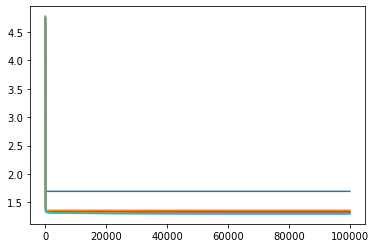

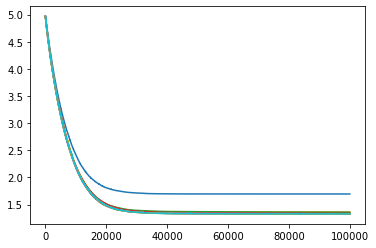

In [45]:
X = generate_feature_matrix(X_train, 9)
(X, mean_norm, std_norm) = normalize_train(X)
training_error_gradient, W_gradient = training_polynomial_regression(Y_train, X, gradient_descent)
training_error_stochastic, W_stochastic = training_polynomial_regression(Y_train, X, stochastic_descent)

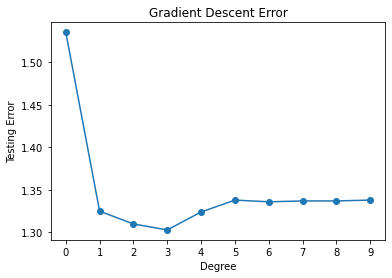

In [46]:
X_grad_test = generate_feature_matrix(X_test, 9)
X_grad_test = normalize_test(X_grad_test, mean_norm, std_norm)

W_grad_mat = [i.reshape([len(i), 1]) for i in W_gradient]
testing_error_gradient = testing_polynomial_regression(Y_test, X_grad_test, W_grad_mat)

rounded_test_error_gradient = [float("{:.3f}".format(testing_error_gradient[i][0])) for i in range(10)]

plt.plot([i for i in range(10)], rounded_test_error_gradient, marker = 'o')
plt.xticks([i for i  in range(10)])
plt.xlabel("Degree")
plt.ylabel("Testing Error")
plt.title("Gradient Descent Error")
plt.savefig("grad_descent_error.png", bbox_inches='tight')
plt.show()

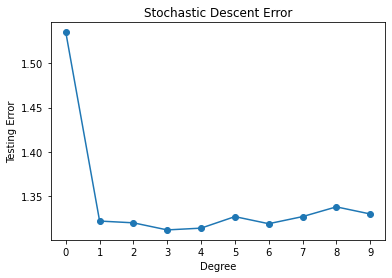

In [47]:
X_stoc_test = generate_feature_matrix(X_test, 9)
X_stoc_test = normalize_test(X_stoc_test, mean_norm, std_norm)

W_stoc_mat = [i.reshape([len(i), 1]) for i in W_stochastic]
testing_error_stochastic = testing_polynomial_regression(Y_test, X_stoc_test, W_stoc_mat)

rounded_test_error_stochastic = [float("{:.3f}".format(testing_error_stochastic[i][0])) for i in range(10)]

plt.plot([i for i in range(10)], rounded_test_error_stochastic, marker = 'o')
plt.xticks([i for i  in range(10)])
plt.xlabel("Degree")
plt.ylabel("Testing Error")
plt.title("Stochastic Descent Error")
plt.savefig("sgd_error.png", bbox_inches='tight')
plt.show()

In [30]:
degrees = np.array([i for i in range(10)]).reshape([10,1])
polynomial_regression_result = np.concatenate((degrees, training_error_gradient, training_error_stochastic, testing_error_gradient, testing_error_stochastic), axis = 1)

In [31]:
polynomial_regression_table = pd.DataFrame(polynomial_regression_result, columns = ['Degree', 'Training Error (Gradient)', 'Training Error (Stochastic)','Testing Error (Gradient)', 'Testing Error (Stochastic)'])
polynomial_regression_table

,Degree,Training Error (Gradient),Training Error (Stochastic),Testing Error (Gradient),Testing Error (Stochastic)
0,0.0,1.6944,1.6944,1.534838,1.534624
1,1.0,1.3606,1.3608,1.324867,1.323926
2,2.0,1.3325,1.3570,1.309989,1.318076
3,3.0,1.3269,1.3370,1.303107,1.309406
4,4.0,1.3187,1.3306,1.323781,1.316062
5,5.0,1.3101,1.3302,1.338475,1.325186
6,6.0,1.3055,1.3295,1.336455,1.323378
7,7.0,1.3022,1.3291,1.337395,1.330144
8,8.0,1.2991,1.3280,1.337464,1.334542
9,9.0,1.2970,1.3271,1.338169,1.335491


Since the testing error is the least for degree 3, we can conclude that polynomial regression of degree 3 best fits the given dataset.

# REGULARIZATION

### Regularized Cost Function

We calculate cost function for regularized linear regression as follows:

$$ J_{reg}(\textbf{w}) = \frac{1}{2} \sum_{i=1}^N (y_{i} - f_{\textbf{w}}(\textbf{x}_{i}))^2 + \frac{\lambda}{2} \sum_{j=1}^M |w_j|^q $$

$$ J_{reg}(\textbf{w}) = \frac{1}{2} (Y - W^TX) (Y - W^TX)^T + \frac{\lambda}{2} \sum_{j=1}^M |w_j|^q $$

The bias, $w_0$ is not regularized.

In [48]:
def regularized_cost_function(Y, X, W, lam, q):
    
    # np.sum is used here to extract the scalar from (1,1) numpy array
    cost1 = 0.5 * np.sum((Y - W.T @ X) @ (Y - W.T @ X).T)
    
    cost2 = (lam / 2) * np.sum(np.power(np.abs(W[1:]), q))

    return cost1 + cost2

### Regularized Linear Regression

We implement regularized linear regression by updating the weights for a fixed number of iterations:

$$ w_j = w_j - \alpha\frac{\partial J_{reg}(\textbf{w})}{\partial w_j} $$

where $\alpha$ is the learning rate, and

$$ \frac{\partial J_{reg}(\textbf{w})}{\partial w_j} = \sum_{i=1}^{N} (y_{i} - f_{\textbf{w}}(\textbf{x}_{i}))(-x_{i_j}) + \frac{\lambda}{2} q|w_j|^{q-1} \frac{w_j}{|w_j|}  $$

In [49]:
def regularized_gradient_descent(Y, X, W, q, alpha, l, iterations):
    N = X.shape[1]
    cost = np.zeros(iterations)
    
    for i in range(iterations):

        W = W - (alpha) * (((-X) @ (Y - W.T @ X).T) + ((l / 2) * q * ((np.power(np.abs(W), (q - 1))) * (W / np.abs(W)))))
        cost[i] = error_function(Y,X,W)

    return W, cost

In [50]:
X_reg_train = np.concatenate((np.ones([1, len(X_train[0])]), X_train), axis = 0)
(X_reg_train, mean_reg, std_reg) = normalize_train(X_reg_train)
Y_reg_train = Y_train

X_reg_test = np.concatenate((np.ones([1, len(X_test[0])]), X_test), axis = 0)
X_reg_test = normalize_test(X_reg_test, mean_reg, std_reg)
Y_reg_test = Y_test

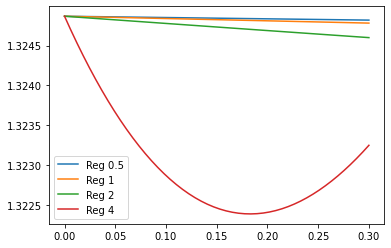

In [51]:
q_vec = [0.5, 1, 2, 4]
lam_vec = np.linspace(0, 0.3, 50)
alpha = 0.0001
iterations = 10000

fig, ax = plt.subplots(1, 1)
for i in range(4):
    q = q_vec[i]
    cost_vec_reg = []
    for l in lam_vec:
        W_l_q = np.ones([3, 1])
        W_l_q, cost = regularized_gradient_descent(Y_reg_train, X_reg_train, W_l_q, q, alpha, l, iterations)
        cost_vec_reg.append(error_function(Y_reg_test, X_reg_test, W_l_q))
    ax.plot(lam_vec, cost_vec_reg, label=f"Reg {q}")

ax.legend()

plt.savefig("reg.png", bbox_inches='tight')
plt.show()

In [52]:
reg_errors_test = []
reg_errors_train = []
lam_values = [167, 113, 10.5, 0.18]

ind = 0
for q in q_vec:
    W_l_q = np.ones([3,1])
    W_l_q, _ = regularized_gradient_descent(Y_reg_train, X_reg_train, W_l_q, q, 0.0001, lam_values[ind], 100000)
    ind += 1
    error = error_function(Y_reg_test, X_reg_test, W_l_q)
    reg_errors_test.append(error)
    reg_errors_train.append(_[-1])

types = ["Unregularized Linear", "Unregularized Cubic", *["Regularized " + str(i) for i in q_vec]]

all_error_testing = [*testing_error_gradient[1], *testing_error_gradient[3], *[e for e in reg_errors_test]]

all_error_training = [*training_error_gradient[1],*training_error_gradient[3], *[e for e in reg_errors_train]]

pd.DataFrame({"Type" : types, "Training RMS" : all_error_training ,"Testing RMS" : all_error_testing})
    


,Type,Training RMS,Testing RMS
0,Unregularized Linear,1.360600,1.324867
1,Unregularized Cubic,1.326900,1.303107
2,Regularized 0.5,1.375088,1.307830
3,Regularized 1,1.375890,1.308257
4,Regularized 2,1.365160,1.320221
5,Regularized 4,1.362957,1.322391


##### Comparison between the best regularized and the best non-regularized model

Of all the regularized models, the one where q is 0.5 performs the best in testing data. Comparing this with the best performing non-regularized polynomial regression model (cubic regression) we can see that cubic regression performs better.

This can be explained as non-regularized linear regression does not overfit the training dataset hence adding regularization does not improve the performance of the model significantly.

# Surface plots of regression models

In [40]:
def predict(x1, x2, degree):
    X_p = []
    for i in range(degree+1):
        for j in range(i+1):
            k = i - j
            X_p.append(np.power(x1, j) * np.power(x2, k))
    X_p = np.array(X_p).reshape(-1, 1)
    d = X_p.shape[0]
    X_p = (X_p - mean_norm[:d]) / std_norm[:d]
    return W_gradient[degree].T @ X_p

In [41]:
def surface_plot(degree):

    fig = plt.figure(figsize=plt.figaspect(0.25))

    ax = fig.add_subplot(1, 2, 1, projection='3d')

    x1 = np.arange(-50, 50, 1.0)
    x2 = np.arange(-50, 50, 1.0)
    X1, X2 = np.meshgrid(x1, x2)
    Z = np.zeros(X1.shape)
    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
            x1 = X1[i][j]
            x2 = X2[i][j]
            Z[i][j] = predict(x1, x2, degree)


    surf = ax.plot_surface(X1, X2, Z, cmap=cm.viridis)
    # surf = ax.plot_surface(X1, X2, Z)
    plt.title("Surface plot of degree " + str(degree))
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.set_zlabel("y(x1, x2)")
    # fig.colorbar(surf, shrink=0.5, aspect=10)

    plt.savefig(f"surf{degree}.png", bbox_inches='tight')
    plt.show()

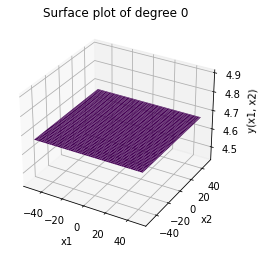

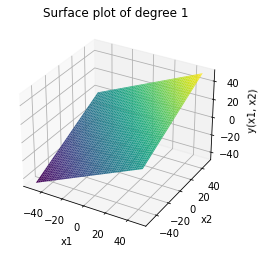

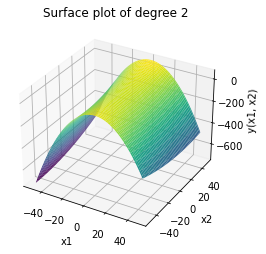

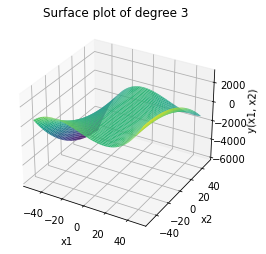

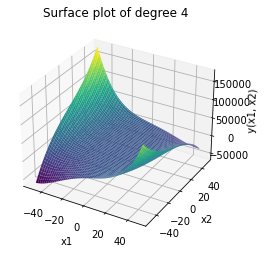

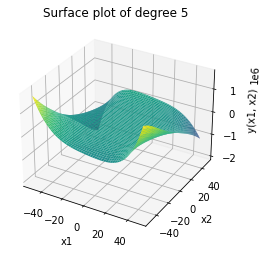

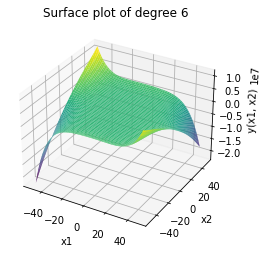

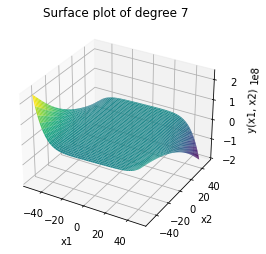

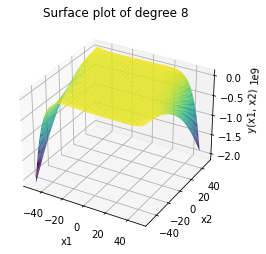

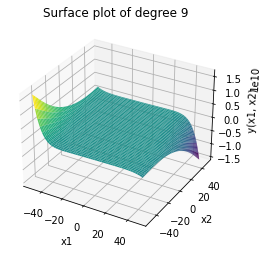

In [42]:
for i in range(10):
    surface_plot(i)